In [1]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.distributed as dist
from torch.multiprocessing import Process
import torchvision

In [3]:
from mpi4py import MPI

In [4]:
from model import MNISTNetwork

In [5]:
import numpy as np
import os
import argparse
from collections import OrderedDict

In [6]:
batch_size = 16
lr = 0.001
momentum = 0.9

In [7]:
def build_mnist_dataloader(train=True, bsz=16):
    """Return a dataloader that lets us iterate through the MNIST dataset."""
    return data.DataLoader(
        torchvision.datasets.MNIST("./", train=train, download=True, transform=torchvision.transforms.ToTensor()),
        shuffle=True,
        num_workers=1,
        batch_size=bsz
    )

In [8]:
def train(model):
    """Define the training process for a single epoch."""
    loader = build_mnist_dataloader(train=True, bsz=batch_size)
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    for k, (xs, ys) in enumerate(loader):
        opt.zero_grad()
        loss_fn(model(xs), ys).backward()
        opt.step()

In [9]:
def eval(model):
    """Define eval function"""
    state_dict = model.state_dict()
    model.load_state_dict(state_dict)
    # --- run validation loop:
    model.eval()
    with torch.no_grad():
        val_losses = []
        val_loader = build_mnist_dataloader(train=False, bsz=batch_size)
        loss_fn = nn.CrossEntropyLoss()
        for xs, ys in val_loader:
            val_losses.append(loss_fn(model(xs), ys).item())
        print("* Mean validation loss of averaged model: {}".format(np.mean(val_losses)))


In [10]:
MNISTNetwork().parameters

<bound method Module.parameters of MNISTNetwork(
  (convnet): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (feedforward): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
)>

In [11]:
import time
start_time = time.time()
nepochs = 1
for t in range(nepochs):
    model = MNISTNetwork()
    train(model)
for t in range(nepochs):
    eval(model)
cpu_time = time.time() - start_time
print(f"time taken to train and eval for {nepochs} epochs: {time.time() - start_time} secs")

* Mean validation loss of averaged model: 0.13383432199433445
time taken to train and eval for 1 epochs: 147.30128860473633 secs


In [12]:
iterations = list(np.logspace(1, 5, base=2, num=5).astype(np.int))

<ipython-input-12-36a55e249440>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iterations = list(np.logspace(1, 5, base=2, num=5).astype(np.int))


In [13]:
iterations

[2, 4, 8, 16, 32]

In [14]:
for i in iterations:
  !mpirun --allow-run-as-root -n  {i} python3 dist_train.py --nepochs 1

[ = = = = = Epoch 0 = = = = = ]
* Waiting for 1 training processes to finish...
(Received a trained model from process 1 of 1 workers...)
* Averaging models...
mpi time with 2 workers: 81.30980448150012
* Mean validation loss of averaged model: 0.1680120046533644
mpi time with 2 workers: 86.41533424350018
[ = = = = = Epoch 0 = = = = = ]
* Waiting for 3 training processes to finish...
mpi time with 4 workers: 69.66058855874985
(Received a trained model from process 1 of 3 workers...)
mpi time with 4 workers: 72.76060627949983
(Received a trained model from process 2 of 3 workers...)
(Received a trained model from process 3 of 3 workers...)
* Averaging models...
mpi time with 4 workers: 73.77871088699999
* Mean validation loss of averaged model: 0.14815446297600865
mpi time with 4 workers: 76.65671905725003
[ = = = = = Epoch 0 = = = = = ]
* Waiting for 7 training processes to finish...
mpi time with 8 workers: 72.93654012774994
(Received a trained model from process 1 of 7 workers...)
mp

In [15]:
mpi_times = [81.30, 69.66, 72.93, 69.37, 53.9]

In [17]:
speed_up = [cpu_time/mpi_time for mpi_time in mpi_times]

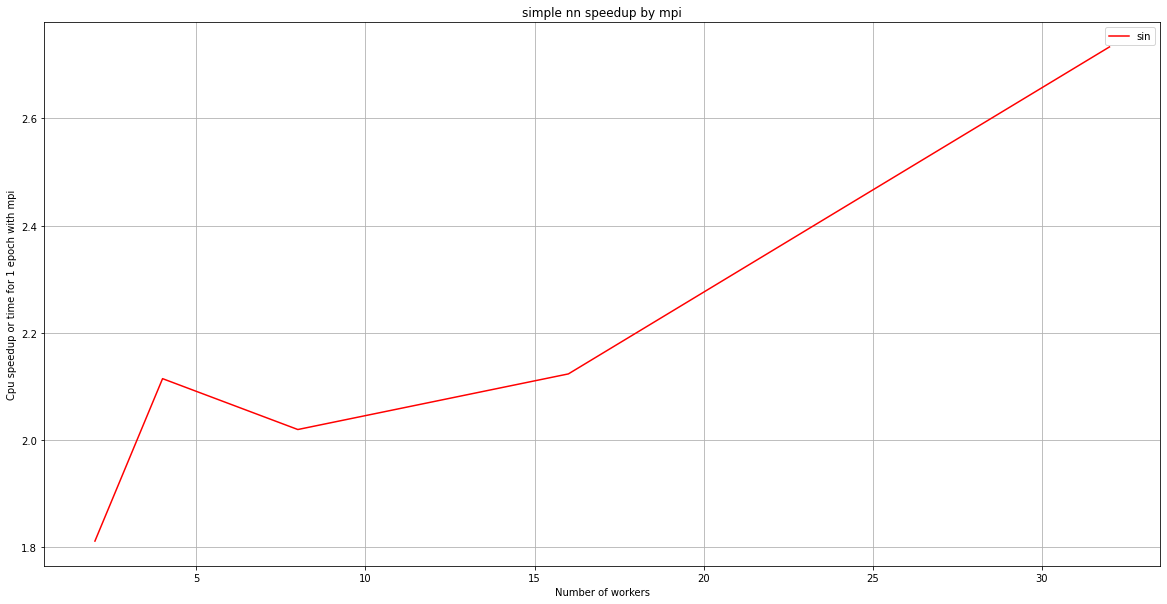

In [21]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(iterations, speed_up, color='r', label='sin')

plt.xlabel("Number of workers")
plt.ylabel("Cpu speedup or time for 1 epoch with mpi")
plt.title("simple nn speedup by mpi")

plt.legend()
plt.grid()

plt.show()